## FedSatShift - Visualisation after domain shift

- **Region A**: Haze (x0.8 + noise)
- **Region B**: Color shift (uniform offset)
- **Region C**: High contrast (x1.2)
- **Region D**: Normal (control)

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
from sklearn.metrics.pairwise import cosine_similarity
import os

In [5]:
DATASET_DIR = '../dataset'
REGIONS = ['A', 'B', 'C', 'D']
REGION_NAMES = {'A': 'Haze', 'B': 'Color Shift', 'C': 'High Contrast', 'D': 'Normal'}
COLORS = {'A': 'red', 'B': 'blue', 'C': 'green', 'D': 'gray'}

region_data = {}
for r in REGIONS:
    path = os.path.join(DATASET_DIR, f'region_{r}.npz')
    data = np.load(path)
    region_data[r] = {'X': data['X'], 'y': data['y']}
    print(f"Region {r} ({REGION_NAMES[r]}): {data['X'].shape[0]} samples")

Region A (Haze): 11500 samples
Region B (Color Shift): 7000 samples
Region C (High Contrast): 8500 samples
Region D (Normal): 27000 samples


### 1. Feature statistics by region

C:\Users\bgdj2\AppData\Local\Temp\ipykernel_15176\2533155549.py:4: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  bp = ax.boxplot(data_norm, labels=[f"{r}: {REGION_NAMES[r]}" for r in REGIONS], patch_artist=True)


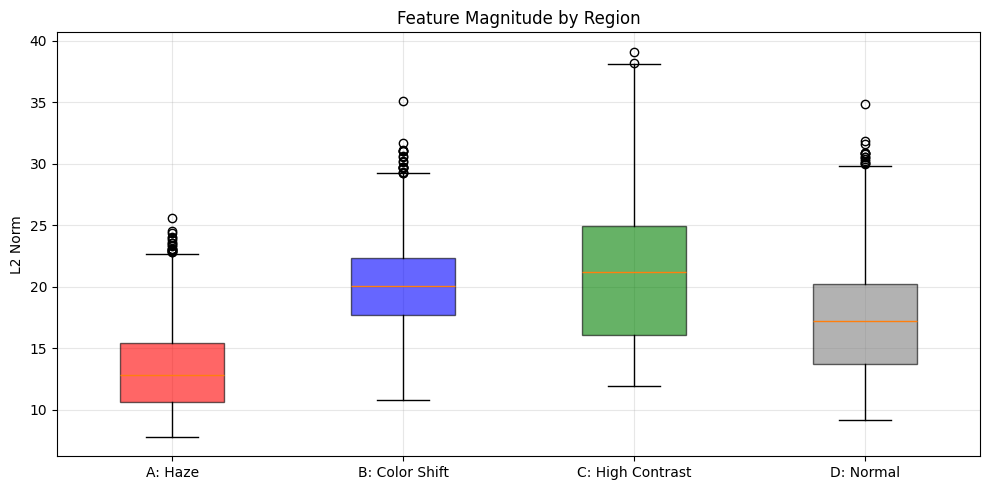

In [19]:
fig, ax = plt.subplots(figsize=(10, 5))

data_norm = [np.linalg.norm(region_data[r]['X'], axis=1) for r in REGIONS]
bp = ax.boxplot(data_norm, labels=[f"{r}: {REGION_NAMES[r]}" for r in REGIONS], patch_artist=True)

for patch, r in zip(bp['boxes'], REGIONS):
    patch.set_facecolor(COLORS[r])
    patch.set_alpha(0.6)

ax.set_ylabel('L2 Norm')
ax.set_title('Feature Magnitude by Region')
ax.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

### 2. PCA Scatter Plot

In [13]:
SAMPLE_PER_REGION = 500

X_all = []
region_labels = []

for r in REGIONS:
    X = region_data[r]['X']
    idx = np.random.choice(len(X), min(SAMPLE_PER_REGION, len(X)), replace=False)
    X_all.append(X[idx])
    region_labels.extend([r] * len(idx))

X_all = np.vstack(X_all)
region_labels = np.array(region_labels)

print(f"Samples for visualization: {len(X_all)}")

Samples for visualization: 2000


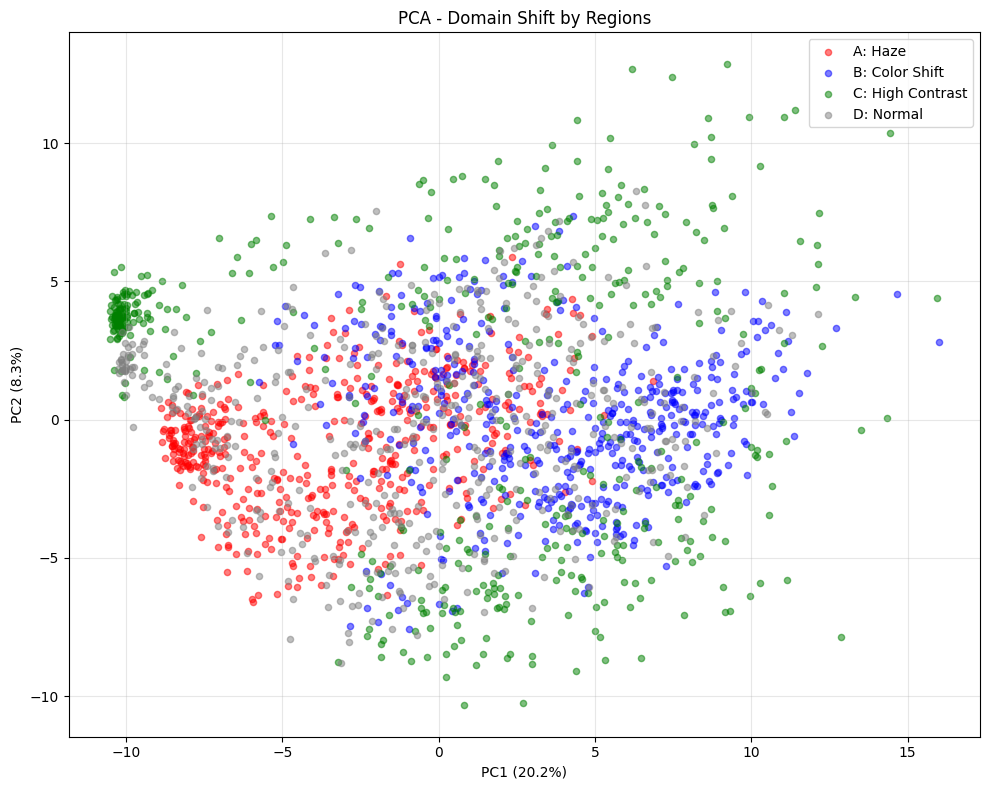

In [12]:
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_all)

fig, ax = plt.subplots(figsize=(10, 8))

for r in REGIONS:
    mask = region_labels == r
    ax.scatter(X_pca[mask, 0], X_pca[mask, 1], 
               c=COLORS[r], label=f'{r}: {REGION_NAMES[r]}', 
               alpha=0.5, s=20)

ax.set_xlabel(f'PC1 ({pca.explained_variance_ratio_[0]*100:.1f}%)')
ax.set_ylabel(f'PC2 ({pca.explained_variance_ratio_[1]*100:.1f}%)')
ax.set_title('PCA - Domain Shift by Regions')
ax.legend()
ax.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

### 3. t-SNE Scatter Plot

In [14]:
tsne = TSNE(n_components=2, random_state=42, perplexity=30)
X_tsne = tsne.fit_transform(X_all)

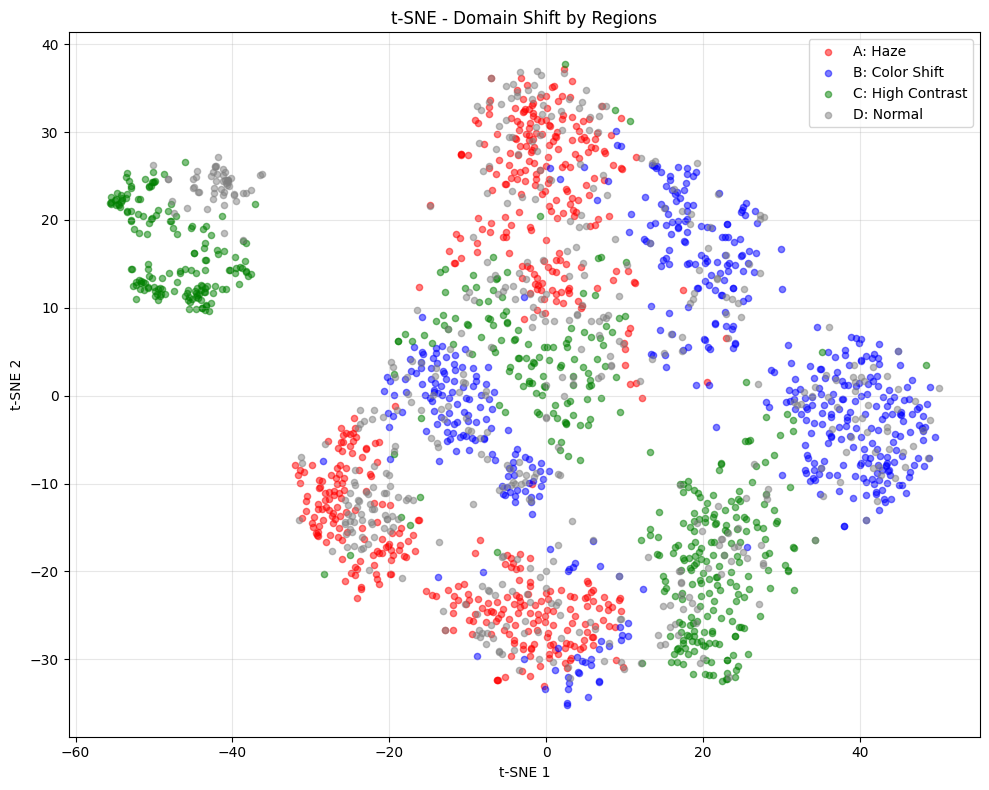

In [15]:
fig, ax = plt.subplots(figsize=(10, 8))

for r in REGIONS:
    mask = region_labels == r
    ax.scatter(X_tsne[mask, 0], X_tsne[mask, 1], 
               c=COLORS[r], label=f'{r}: {REGION_NAMES[r]}', 
               alpha=0.5, s=20)

ax.set_xlabel('t-SNE 1')
ax.set_ylabel('t-SNE 2')
ax.set_title('t-SNE - Domain Shift by Regions')
ax.legend()
ax.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

### 4. Cosine Similarity Heatmap

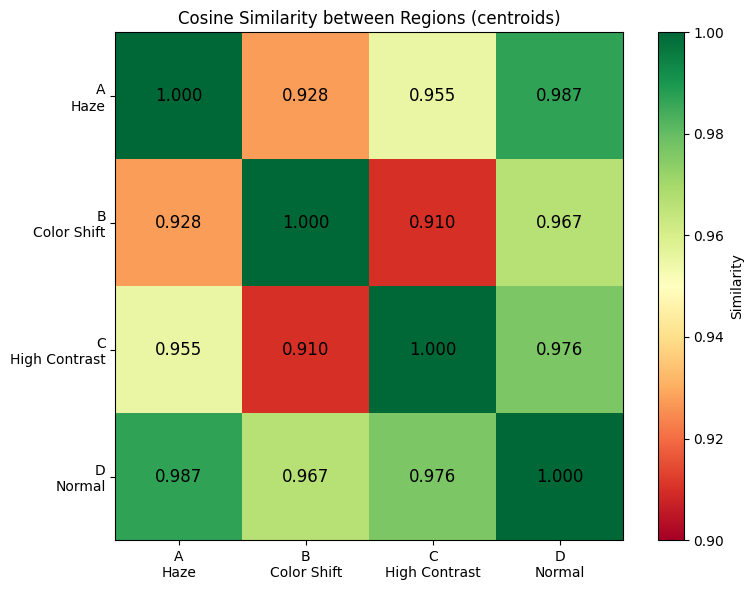

In [16]:
centroids = {}
for r in REGIONS:
    centroids[r] = np.mean(region_data[r]['X'], axis=0)

n = len(REGIONS)
sim_matrix = np.zeros((n, n))

for i, r1 in enumerate(REGIONS):
    for j, r2 in enumerate(REGIONS):
        sim_matrix[i, j] = cosine_similarity([centroids[r1]], [centroids[r2]])[0][0]

fig, ax = plt.subplots(figsize=(8, 6))
im = ax.imshow(sim_matrix, cmap='RdYlGn', vmin=0.9, vmax=1.0)

ax.set_xticks(range(n))
ax.set_yticks(range(n))
ax.set_xticklabels([f'{r}\n{REGION_NAMES[r]}' for r in REGIONS])
ax.set_yticklabels([f'{r}\n{REGION_NAMES[r]}' for r in REGIONS])

for i in range(n):
    for j in range(n):
        ax.text(j, i, f'{sim_matrix[i,j]:.3f}', ha='center', va='center', fontsize=12)

ax.set_title('Cosine Similarity between Regions (centroids)')
plt.colorbar(im, ax=ax, label='Similarity')
plt.tight_layout()
plt.show()